In [1]:
import pandas as pd

df = pd.read_csv('c:/data/spam/spam.csv',encoding='latin1')
df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_5044\882351455.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
# ham => 0, spam => 1 로 바꾸어 저장

df['v1'] = df['v1'].replace(['ham','spam'],[0,1])
df[:5]

C:\Users\user\AppData\Local\Temp\ipykernel_5044\183987525.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['v1'] = df['v1'].replace(['ham','spam'],[0,1])


,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.shape

(5572, 2)

v1
0    4825
1     747
Name: count, dtype: int64


<Axes: xlabel='v1'>

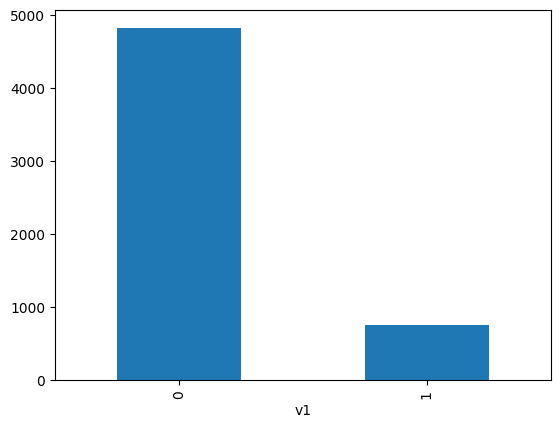

In [4]:
print(df['v1'].value_counts())

df['v1'].value_counts().plot(kind='bar')

In [5]:
X=df[['v2']] # 독립변수
y=df['v1'] # 종속변수

print(X[:3])
print(y[:3])

                                                  v2
0  Go until jurong point, crazy.. Available only ...
1                      Ok lar... Joking wif u oni...
2  Free entry in 2 a wkly comp to win FA Cup fina...
0    0
1    0
2    1
Name: v1, dtype: int64


v1
0    747
1    747
Name: count, dtype: int64


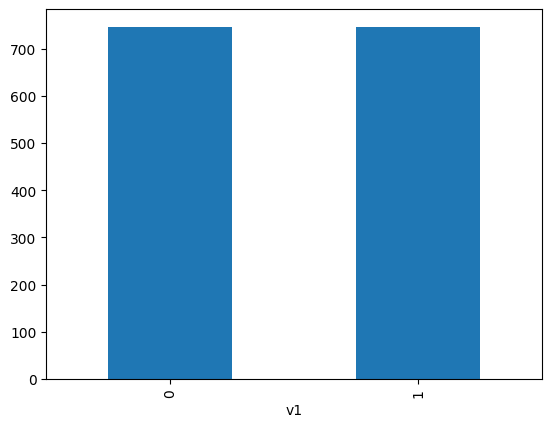

In [6]:
# 언더샘플링
from imblearn.under_sampling import RandomUnderSampler

X_sample, y_sample = RandomUnderSampler(random_state=0).fit_resample(X, y)
X_samp = pd.DataFrame(data=X_sample,columns=['v2'] )
y_samp = pd.DataFrame(data=y_sample,columns=['v1'])
df_samp=pd.concat([X_samp,y_samp],axis=1)

print(df_samp['v1'].value_counts())

df_samp['v1'].value_counts().plot(kind='bar')
X = df_samp['v2']
y = df_samp['v1']

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

# 단어 집합을 만들고 단어에 고유한 숫자 인덱스를 부여

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

# 텍스트를 시퀀스로 변환(단어의 인덱스로만 구성된 새로운 리스트)

sequences = tokenizer.texts_to_sequences(X)

print(sequences[:5])

[[1486, 49, 801, 1487, 18, 336, 87, 26, 2274, 45, 27, 173], [1148, 14, 4, 25, 613], [174, 149, 4, 2, 189, 5, 105, 17, 614, 613], [946, 88, 38, 399, 702, 1, 2275, 1488, 130, 2276, 26, 1489, 242, 45, 702, 1, 2277, 2278, 24, 46, 1149], [7, 291, 1490, 802, 553, 53, 316, 26, 803, 703, 25, 63, 47, 217, 1491, 13, 434, 337, 97]]


In [8]:
# 단어와 인덱스 목록

word_to_index = tokenizer.word_index

for idx,word in enumerate(word_to_index):
    print(idx+1,word,end=',')
    if idx>8:
        break

1 to,2 you,3 a,4 call,5 i,6 the,7 u,8 your,9 for,10 is,

메일의 최대 길이 : 77
19.846050870147256


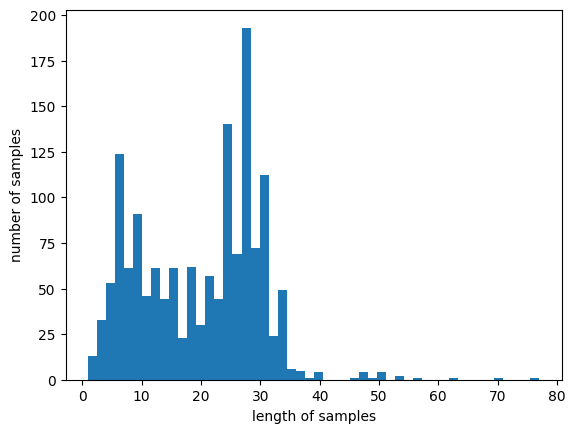

In [9]:
import matplotlib.pyplot as plt

X_data = sequences

print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print(sum(map(len, X_data))/len(X_data)) #메일의 평균 길이

plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples') # 길이
plt.ylabel('number of samples') # 샘플수
plt.show()

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 최대 사이즈에 맞추어 빈칸에 0으로 채움

data = pad_sequences(X_data, maxlen = 77)

print("학습용 데이터의 크기(shape): ", data.shape)
print(data[:1])

학습용 데이터의 크기(shape):  (1494, 77)
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0 1486   49  801 1487   18
   336   87   26 2274   45   27  173]]


In [11]:
# 학습용:검증용 8:2로 구분
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, stratify=y, random_state=10)

In [12]:
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential

model = Sequential()

# Embedding(단어수,출력사이즈,최대단어수)
model.add(Embedding(len(word_to_index)+1, input_shape=(32,)))
model.add(LSTM(32)) # Long Short-Term Memory
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

TypeError: Embedding.__init__() missing 1 required positional argument: 'output_dim'

In [ ]:
hist = model.fit(X_train, y_train.values, epochs=10, batch_size=64, validation_split=0.2)

In [ ]:
model.evaluate(X_test, y_test.values, verbose=0)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','val_loss','accuracy','val_accuracy'])
plt.grid()
plt.show()

In [ ]:
model.predict(X_test[:3])